In [31]:
import numpy
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.optimize
%matplotlib inline
from numpy import asarray

In [32]:
# t1 is for Cx and t2 is for rCO2 (both are in hours)
t1 = numpy.array([1.5, 2.5, 3.5, 4.5, 5.5])
t2 = [1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25] 

In [33]:
# A1
Cx_A = [0.8482, 0.9537, 1.3007, 1.6067, 2.0595] # g/L
rco2_A = [2.60, 3.00, 3.70, 4.00, 4.70, 5.20, 6.10, 7.10, 8.10] # ml/min

In [34]:
# B1
Cx_B = [1.0805, 1.2477, 1.5965, 1.9085, 2.3736] # g/L
rco2_B = [3.20, 3.68, 4.23, 5.67, 8.098, 7.8, 7.88, 7.6, 7.3] # ml/min

In [35]:
# C1
Cx_C = [1.8127, 2.0228, 2.0248, 2.3736, 2.6795] # g/L
rco2_C = [12, 11, 10.5, 6.65, 7.2, 7.619, 8.2759, 9.166, 9.68] # ml/min

In [36]:
Cx_avg=[]
for index,value in enumerate(Cx_A):
       sum_avg=Cx_A[index]+Cx_B[index]
       Cx_avg.append(sum_avg/2)

Cx_avg 

[0.96435, 1.1007, 1.4485999999999999, 1.7576, 2.21655]

In [37]:
#rco2_avg=[]
#for index,value in enumerate(rco2_A):
#    sum_avg=rco2_A[index]+rco2_C[index]+rco2_B[index]
#    rco2_avg.append(sum_avg/3)

rco2_avg = rco2_A

# determintation of Cx0

In [38]:
def bio(t,mu1,CA0):

    return CA0*scipy.e**(mu1*(t))

In [39]:
t3 = numpy.array([0,1.5, 2.5, 3.5, 4.5, 5.5])

0.21716830093326497 0.6681169974267407


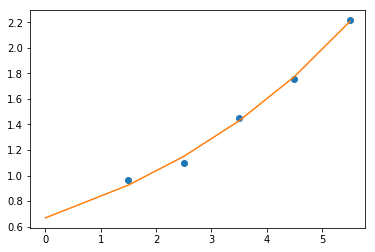

In [40]:
params = scipy.optimize.curve_fit(bio,t1,Cx_avg,p0 =(0.5,0.5))[0]
mu_fit,Ca0_fit = params

print (mu_fit,Ca0_fit)

Cx_fit= bio(t3,mu_fit,Ca0_fit)

plt.plot(t1,Cx_avg,"o")
plt.plot(t3,Cx_fit)

# Calculations

In [77]:
alpha, beta, theta = 0.1, 0.1, 0.05
gamma = 1.29
mu = mu_fit
mu

0.21716830093326497

In [78]:
def response_fun(C):
    
    Cx, Ce, Cs = C
        
    S = numpy.matrix([[-1, 1+alpha,    1,   0,   0],
                      [ 0,       0,   -1,   1, 1.5],
                      [ 0,    beta,    0,-1/3,   0],
                      [ 0,  -gamma, -1/3,   0,   1],
                      [ 0,       1,    0,   0,   0]])

    sol = numpy.matrix([0, 0, 0, theta, mu]).T
    r = numpy.linalg.solve(S, sol) 
        
    
    return [mu,        # biomass
            r[4, 0],    # ethanol  
            r[0, 0]]   # glucose

In [79]:
def ferm_eq(C,t):
    Cx, Ce, Cs = C 
    r=response_fun(C)
    
    return [r[0]*Cx,
            r[1]*Cx,
            r[2]*Cx]   

# Biomass production  rate

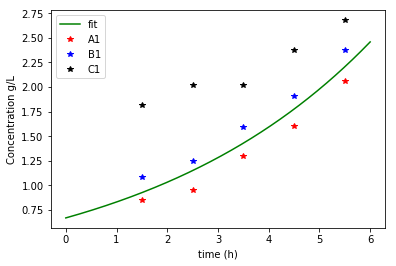

In [87]:
Cx0 = Ca0_fit

Co=[Cx0, 0, (35*2)/30]
tmax = 6
tspan=numpy.linspace(0,tmax,tmax*100+1)            
C = odeint(ferm_eq, Co, tspan)

Cx = C[:,0]      
Ce = C[:,1]

plt.plot(tspan, Cx, color='green',label='fit')
plt.plot(t1, Cx_A,'*', color='red', label='A1')
plt.plot(t1, Cx_B,'*', color='blue', label='B1')
plt.plot(t1, Cx_C, '*', color='black', label='C1')

plt.legend(loc='best')
plt.ylabel('Concentration g/L') 
plt.xlabel('time (h)') 
plt.show()

# CO2 production rate

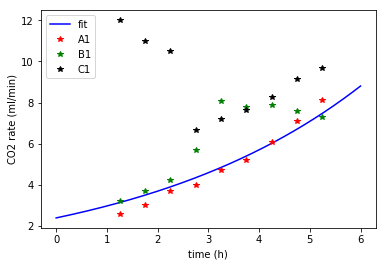

In [89]:
Ci=(C[:, :1])                                  
r=asarray([response_fun(C) for C in C])        

T, P = 23, 87  # °C, kPa 

rx=r[:,0]
re=r[:,1]
rco2=(0.5*re+alpha*rx)*(1/60)*8.314*(T+273)*1000/P*(Cx/24.6)*0.5  #ml CO2/min   

plt.plot(tspan, rco2, color='blue', label='fit')
plt.plot(t2, rco2_A, '*', color='red',label='A1')
plt.plot(t2, rco2_B, '*', color='green',label='B1')
plt.plot(t2, rco2_C, '*', color='black',label='C1')

plt.legend(loc='best')
plt.ylabel('CO2 rate (ml/min)') 
plt.xlabel('time (h)') 
plt.show()

# Jarryd's shit

In [82]:
def ferm_eq_2(t,C):
    Cx, Ce, Cs = C 
    r=response_fun_2(C)
    
    return [r[0]*Cx,
            r[1]*Cx,
            r[2]*Cx]   

In [83]:
error=1000

for gamma in numpy.arange(0,2,0.01):
    squares=0
    
    def response_fun_2(C):
    
        Cx, Ce, Cs = C

        S = numpy.matrix([[-1,1+alpha,1,0,0],
                          [ 0,0,-1,1,1.5],
                          [  0,beta,0,-1/3,0],
                          [ 0,-gamma,-1/3,0,1],
                          [ 0,1,0,0,0]])

        sol = numpy.matrix([0, 0, 0, theta, mu]).T
        r = numpy.linalg.solve(S, sol) 


        return [mu,        # biomass
                r[4,0],    # ethanol  
                r[0, 0]]   # glucose
    
    Co=[Cx0, 0, (35*2)/30]
    tspan=[0,6]   
#     print (Co)
    C = scipy.integrate.solve_ivp(ferm_eq_2, tspan, Co, t_eval=t2).y
#     print (C)
    
    fitted_rco2_list=[]
    
    for index,value in enumerate(rco2_avg):
#         print ((C[0][index], C[1][index], C[2][index]))
        rates = response_fun_2((C[0][index], C[1][index], C[2][index]))
        rx, re, rs = rates
        cx=Cx[numpy.where(numpy.linspace(0,tmax,tmax*100+1) == t2[index])]
#         print (numpy.where(numpy.linspace(0,tmax,tmax*100+1) == t2[index]))
      
        fitted_rco2 = (0.5*re+alpha*rx)*(1/60)*8.314*(T+273)*1000/P*(cx)/24.6*0.5
#         print (fitted_rco2, value, gamma)
        squares+=(fitted_rco2-value)**2
#         print (squares)
        fitted_rco2_list.append(fitted_rco2)
    if squares<error:
#         print (squares, gamma)
        gamma_acc=gamma
        error=squares
        fitted_rco2_acc=fitted_rco2_list
#     print (squares, gamma)

In [84]:
gamma_acc

1.29

In [85]:
gamma=gamma_acc

[0.21716830093326497, 0.21716830093326497, 0.21716830093326497] [0.7037278765944766, 0.7037278765944766, 0.7037278765944766]


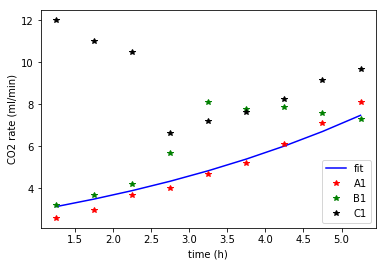

In [90]:
# Ci=(C[:, :1]) 
# print (Ci)
# r=asarray([response_fun(Ci) for C in C])       

r=[]
rx=[]
re=[]
for values in zip(C[0],C[1],C[2]):
    r.append(response_fun(values))
    rx.append(response_fun(values)[0])
    re.append(response_fun(values)[1])
print (rx, re)

T, P = 23, 87  # °C, kPa 
 

plt.plot(t2, fitted_rco2_acc, color='blue', label='fit')
plt.plot(t2, rco2_A, '*', color='red',label='A1')
plt.plot(t2, rco2_B, '*', color='green',label='B1')
plt.plot(t2, rco2_C, '*', color='black',label='C1')

plt.legend(loc='best')
plt.ylabel('CO2 rate (ml/min)') 
plt.xlabel('time (h)') 
plt.show()